# Predictive Modeling

This notebook uses the combined dataset in "full_df_testing.csv" (created by the "create_dataframe" notebook) and implements
different modeling methods to perform predictive analysis
of the inflow and outflow migration for each state.

In [1]:
# Basic data processing tools
import pandas as pd
import numpy as np

# Models for multilinear & polynomial regressions
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Metrics & model processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Plotting
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set_theme()

First, we import our dataset & do some slight cleaning:

In [2]:
df = pd.read_csv("full_df_testing.csv")

# We drop this unnamed 'index' column, as indicies are already autogenerated by pandas
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,State,Number of fires,Number of acres burned,Year,Out,In,GDP,index_nsa,index_sa
0,Alaska,688.0,1129421.0,2010,94848.0,1961604.0,52947.7,219.6675,218.6700
1,Alabama,2357.0,26331.0,2010,99850.0,5871042.0,175470.1,180.6000,179.9575
2,Arkansas,2010.0,30954.0,2010,64264.0,4272858.0,100970.8,178.3550,178.0375
3,Arizona,1517.0,74445.0,2010,177056.0,12027150.0,248125.3,182.9075,182.4725
4,California,6502.0,108742.0,2010,575165.0,24016446.0,1973511.9,164.5075,163.6975


## Selecting features
We are only going to give our models information on `Number of acres burned`, `GDP`, and `index_nsa`. 
Our models will be predicting outflow migration, so only the `Out` column is used.

All other columns should be dropped.

In [3]:
df = df[["Number of acres burned", "GDP", "index_sa", "Out"]]

## Normalizing our data
If we attempted to perform polynomial regression or multilinear regression on the data as it is, the coefficients we get
would not be proportional to the importance of each variable.

Therefore, we will be using min-max normalization on all the dataframe's features. The minimum value turns into a 0, and the maximum a 1.
Every other value is assigned a value between 0 and 1.

In [4]:
def min_max_normalization(column):
    min_value = column.min()
    max_value = column.max()

    normalized_column = (column - min_value) / (max_value - min_value)
    return normalized_column

normalized_df = df.apply(min_max_normalization) # perform normalization on all columns
normalized_df["Out"] = df["Out"] # EXCEPT outflow migration
del df

normalized_df.head()

,Number of acres burned,GDP,index_sa,Out
0,0.220961,0.008318,0.292747,94848.0
1,0.005151,0.047769,0.183724,99850.0
2,0.006056,0.023781,0.178316,64264.0
3,0.014564,0.071164,0.190806,177056.0
4,0.021274,0.626721,0.137932,575165.0


## Quadratic Regression
Our initial model was a simple quadratic regression, predicting migration outflow using only GDP.

Creating the quadratic model:

In [5]:
# Split data into training and testing (80-20 split)
quad_X = np.array(normalized_df["GDP"]).reshape(-1, 1)
quad_y = np.array(normalized_df["Out"]).reshape(-1, 1)
quad_X_train, quad_X_test, quad_y_train, quad_y_test = train_test_split(quad_X, quad_y, test_size=0.2)

# Create quadratic model using training data
poly_features = PolynomialFeatures(degree=2)
quad_model = LinearRegression()
quad_model.fit(poly_features.fit_transform(quad_X_train), quad_y_train)

LinearRegression()

Plotting its performance:

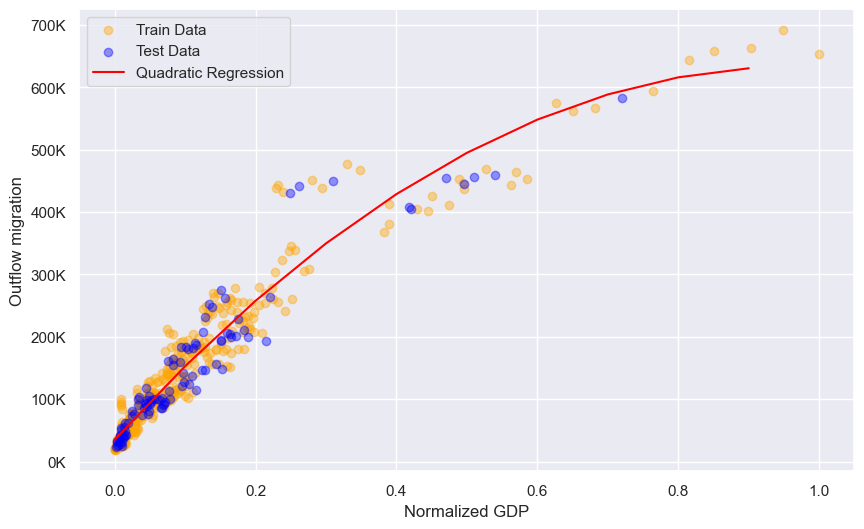

In [6]:
# Generate x-values to plot the curve
x_values = np.arange(quad_X_train.min(), quad_X_train.max(), 0.1)
x_values_poly = poly_features.transform(x_values.reshape(-1, 1))

# Predict the y-values for the curve using the quadratic regression model
y_values_pred = quad_model.predict(x_values_poly)

plt.figure(figsize=(10, 6))

# Plot the results
plt.scatter(quad_X_train, quad_y_train, color='orange', label='Train Data', alpha=0.4)
plt.scatter(quad_X_test, quad_y_test, color='blue', label='Test Data', alpha=0.4)
plt.plot(x_values, y_values_pred, color='red', label='Quadratic Regression')

# Use 'K' instead of 000
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

# Style the graph
plt.legend()
plt.xlabel("Normalized GDP")
plt.ylabel("Outflow migration")
plt.show()



Determining performance on testing data:

In [7]:
# Make predictions on the test data
quad_y_pred = quad_model.predict(poly_features.fit_transform(quad_X_test))

# Evaluate performance metrics
mse = mean_squared_error(quad_y_test, quad_y_pred)
r2 = r2_score(quad_y_test, quad_y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

Mean Squared Error (MSE): 1115834207.5564964
R-squared: 0.9223666390021278


# Multilinear Regression

To be able to consider other features, we also developed a multilinear model.

We select the features to be used, create a test-train split, and train the model:

In [8]:
# Select features & drop N/A values
input_features = ['index_sa', 'GDP', 'Number of acres burned']
output_feature = 'Out'
filtered_df = normalized_df.dropna(subset=[output_feature] + input_features) # drop N/A values
multi_X = filtered_df[input_features]
multi_y = filtered_df[output_feature]

# Perform train-test split
multi_X_train, multi_X_test, multi_y_train, multi_y_test = train_test_split(multi_X, multi_y, test_size=0.4)

# Train the model
multi_model = LinearRegression()
multi_model.fit(multi_X_train, multi_y_train)

# Make predictions for testing data
multi_y_pred = multi_model.predict(multi_X_test)



Before we can use this model in any way, however, we must conduct collinearity checks to ensure that
there aren't any confounding variables in our data:

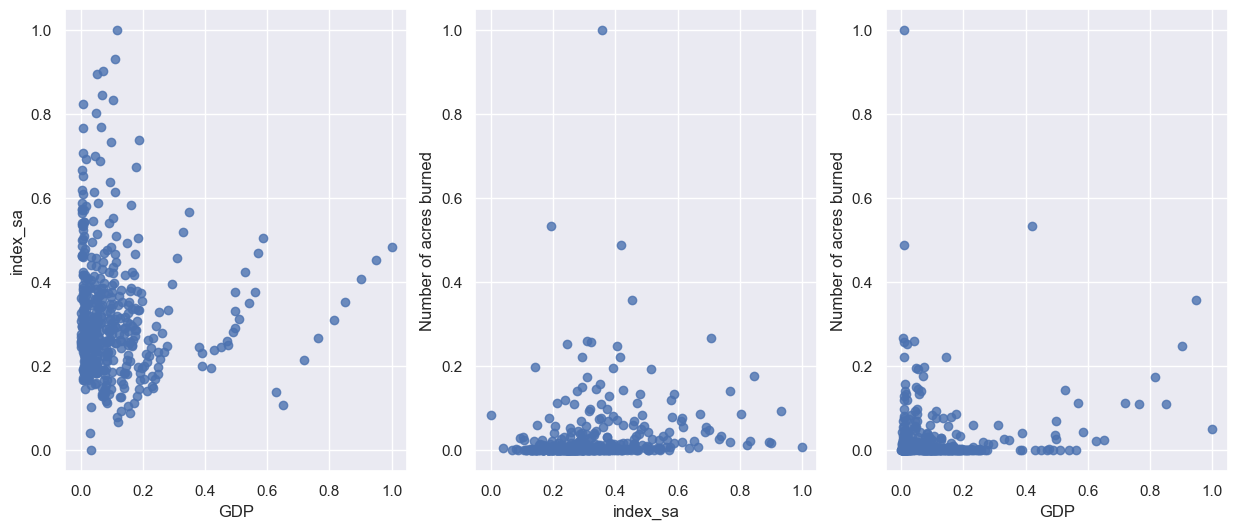

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 6))

sns.regplot(filtered_df, x="GDP", y="index_sa", ax=axs[0], fit_reg=False)
sns.regplot(filtered_df, x="index_sa", y="Number of acres burned", ax=axs[1], fit_reg=False)
sns.regplot(filtered_df, x="GDP", y="Number of acres burned", ax=axs[2], fit_reg=False)
plt.show()

To visualize the accuracy of the model, we decided to plot the predicted migration outflow vs the expected migration outflow, using the Testing Prediction dataset:

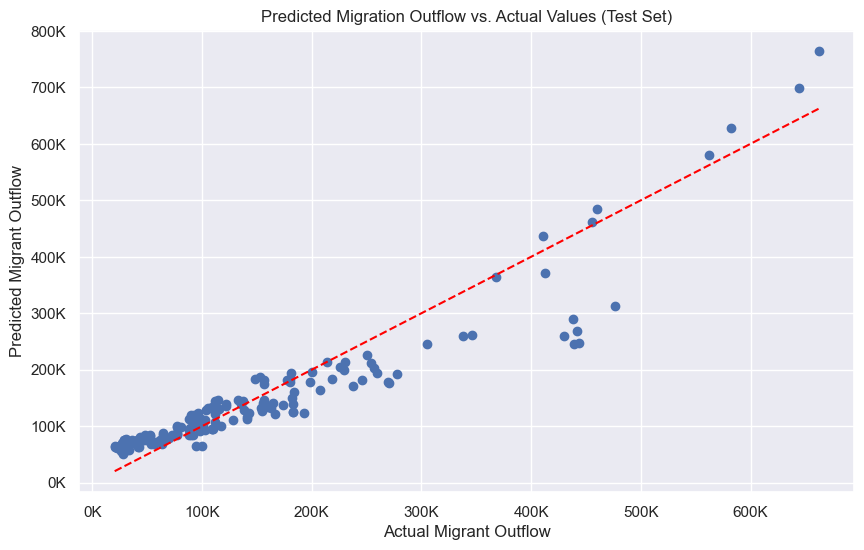

In [10]:
plt.figure(figsize=(10, 6))

plt.scatter(multi_y_test, multi_y_pred)
plt.plot([min(multi_y_test), max(multi_y_test)], [min(multi_y_test), max(multi_y_test)], linestyle='--', color='red')

plt.xlabel("Actual Migrant Outflow")
plt.ylabel("Predicted Migrant Outflow")
plt.title("Predicted Migration Outflow vs. Actual Values (Test Set)")

# Use 'K' instead of 000
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K')) 
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()


We also assess performance quantitatively:

In [11]:
# Evaluate performance metrics
mse = mean_squared_error(multi_y_test, multi_y_pred)
r2 = r2_score(multi_y_test, multi_y_pred)
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

Mean Squared Error (MSE): 2046310710.0638115
R-squared: 0.8700082469247253


And determine the coefficients:

In [12]:
list(zip(input_features, multi_model.coef_))

[('index_sa', -31895.818143229717),
 ('GDP', 785446.9410628233),
 ('Number of acres burned', -15992.740768338694)]